# Lessons from discrete WGANS
In this colab we will reproduce some of the experiment in the [paper](https://openreview.net/forum?id=7YXaOvunqo) and get a taste of the main result of our paper i.e. that training of WGAN with minibatches can reach the optimal solution of the wasserstein minimization problem.


## Prepare code and data
The squares dataset is a toy synthetic dataset of 2704 64x64 images with 10x10 in random locations that is generated by a python script. We will use it for the experiments in tis colab.

In [1]:
!git clone https://github.com/ariel415el/DiscreteGANs.git
%cd DiscreteGANs
!pip install -r requirements.txt
from IPython.display import display
from PIL import Image
!python3 scripts/create_squares_dataset.py

Cloning into 'DiscreteGANs'...
remote: Enumerating objects: 1968, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 1968 (delta 71), reused 107 (delta 51), pack-reused 1816 (from 1)
Receiving objects: 100% (1968/1968), 20.99 MiB | 1.26 MiB/s, done.
Resolving deltas: 100% (1350/1350), done.
/mnt/storage_ssd/university/repos/In_defence_of_wasserstein/colab_test/DiscreteGANs


/mnt/storage_ssd/university/new_venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Defaulting to user installation because normal site-packages is not writeable
Created 2704 images


# 1 - Direct optimiazation for optimal solution
As a reference to how the optimal solution for the wasserstein minimization problem looks we use the OTMeans for the image-level problem and and direct patch-SWD for the patch-level problem

As can be seen the resulting images show correct global features (number of squares in each images) but lack local features (blurry square edges)

 ## 1.1 - OTMeans
 OT means is an algorithm we develop and use in the paper. It purpose is to show what is the optimal solution for the discrete Wasserstein minimization looks like.
The code below shows the solution for N=2704 M=64 in the Squares dataset looks like.

please refer to the paper for more details and an explanation why this algorithm's results represent the optimal solution.

In [2]:
!python3 scripts/ot_means.py --data_path black_S-10_O-1_S-1 --gray_scale --k 64

100%|█████████████████████████████████████| 2704/2704 [00:00<00:00, 3401.58it/s]
Running OTmeans with k=64 on data of shape torch.Size([2704, 1, 64, 64])
  0%|                                                    | 0/10 [00:00<?, ?it/s]Iter: 0
 MiniBatchLoss-dist=w1: 12.4256
 MiniBatchLoss-dist=swd: 0.0566
 10%|████▍                                       | 1/10 [00:00<00:02,  3.23it/s]Iter: 1
 MiniBatchLoss-dist=w1: 12.3147
 MiniBatchLoss-dist=swd: 0.0552
 20%|████████▊                                   | 2/10 [00:00<00:02,  3.55it/s]Iter: 2
 MiniBatchLoss-dist=w1: 12.2994
 MiniBatchLoss-dist=swd: 0.0550
 30%|█████████████▏                              | 3/10 [00:00<00:01,  3.68it/s]Iter: 3
 MiniBatchLoss-dist=w1: 12.2874
 MiniBatchLoss-dist=swd: 0.0549
 40%|█████████████████▌                          | 4/10 [00:01<00:01,  3.75it/s]Iter: 4
 MiniBatchLoss-dist=w1: 12.2770
 MiniBatchLoss-dist=swd: 0.0542
 50%|██████████████████████                      | 5/10 [00:01<00:01,  3.78it/s]Iter: 

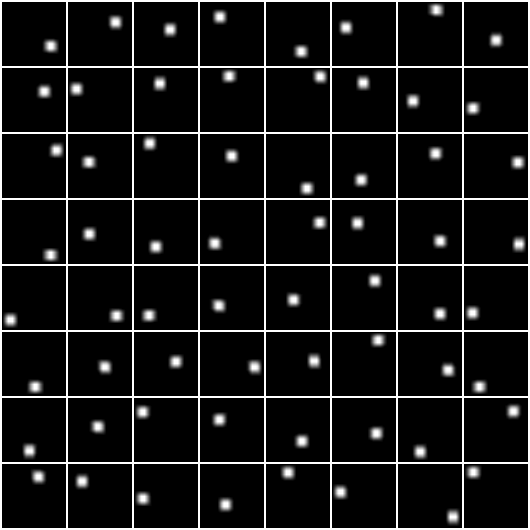

In [3]:
display(Image.open("outputs/OTMeans/black_S-10_O-1_S-1_M-weisfeld_I-64_K-64/images/otMeans-8.png"))

## 1.2 - Direct patchSWD minimization
Since there are way too many patches in each image the use of OTMeans in the patch-level is impractical. We thereforetrain a generator in a similar way to GAN training only that there is no discriminator involved and the only loss is an SWD (an approximation of W1) between the patches of sampled fake and real batches.

As can be seen the resulting images show correct local features (sharp edges) but lack global structure (number of squares in each images)

In [4]:
!python3 train.py --data_path black_S-10_O-1_S-1 --gray_scale --z_prior const=64 --gen_arch FC --lrG 0.001 --loss_function MiniBatchPatchLoss-dist=swd-p=16-s=1 --D_step_every -1 --train_name DirectSWD --n_iterations 10000 --log_freq 5000 --full_batch_metrics MiniBatchLoss-dist=w1 MiniBatchLocalPatchLoss-dist=swd-p=16-s=8

Working on device: NVIDIA GeForce RTX 3060 Ti
Train images: 2704, test images: 0
Train images: 2704, test images: 0
G params: 536.70K, D params: 2.76M
Iteration: 0: it/sec: 3.8
Generating images in minibatches
Computing metrics between 2704 real and 64 fake images
	 - MiniBatchLoss-dist=w1
	 - MiniBatchLocalPatchLoss-dist=swd-p=16-s=8
Evaluation finished in 2.656126022338867 seconds
Iteration: 100: it/sec: 12.2
Iteration: 200: it/sec: 14.7
Iteration: 300: it/sec: 15.9
Iteration: 400: it/sec: 16.6
Iteration: 500: it/sec: 17.0
Iteration: 600: it/sec: 17.2
Iteration: 700: it/sec: 17.4
Iteration: 800: it/sec: 17.6
Iteration: 900: it/sec: 17.8
Iteration: 1000: it/sec: 17.9
Iteration: 1100: it/sec: 18.0
Iteration: 1200: it/sec: 18.1
Iteration: 1300: it/sec: 18.2
Iteration: 1400: it/sec: 18.2
Iteration: 1500: it/sec: 18.3
Iteration: 1600: it/sec: 18.3
Iteration: 1700: it/sec: 18.4
Iteration: 1800: it/sec: 18.4
Iteration: 1900: it/sec: 18.5
Iteration: 2000: it/sec: 18.5
Iteration: 2100: it/sec

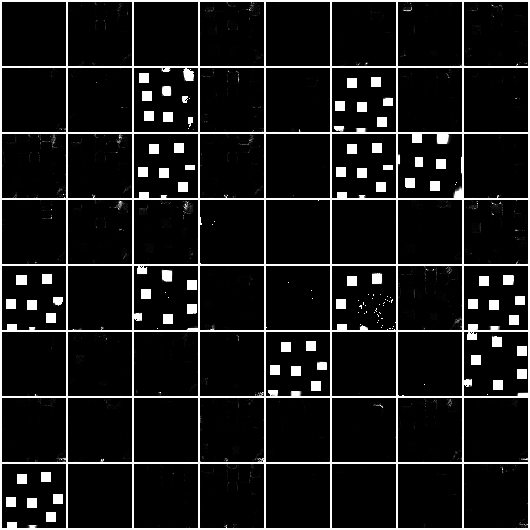

In [5]:
display(Image.open("outputs/GANs/DirectSWD/images/10000.png.png"))

# 2 - Train discreteWGAN


## 2.1 - FC discriminator with M<N
In this scenario we get similar visual results to that of OTMeans when M<N (blurry squares)

In [6]:
!python3 train.py --data_path black_S-10_O-1_S-1 --gray_scale  --z_prior const=64 --gen_arch FC --disc_arch FC-nf=1024 --lrD 0.001 --loss_function WGANLoss --gp_weight 10 --G_step_every 5 --train_name DiscreteWGAN-FC --full_batch_metrics MiniBatchLoss-dist=w1 --n_iterations 20000 --log_freq 10000

Working on device: NVIDIA GeForce RTX 3060 Ti
Train images: 2704, test images: 0
Train images: 2704, test images: 0
G params: 536.70K, D params: 6.30M
Iteration: 0: it/sec: 1.8
Generating images in minibatches
Computing metrics between 2704 real and 64 fake images
	 - MiniBatchLoss-dist=w1
Evaluation finished in 1.339080810546875 seconds
Iteration: 100: it/sec: 31.1
Iteration: 200: it/sec: 46.0
Iteration: 300: it/sec: 54.4
Iteration: 400: it/sec: 61.0
Iteration: 500: it/sec: 64.8
Iteration: 600: it/sec: 67.7
Iteration: 700: it/sec: 70.5
Iteration: 800: it/sec: 72.2
Iteration: 900: it/sec: 74.1
Iteration: 1000: it/sec: 75.7
Iteration: 1100: it/sec: 74.8
Iteration: 1200: it/sec: 76.1
Iteration: 1300: it/sec: 77.2
Iteration: 1400: it/sec: 77.7
Iteration: 1500: it/sec: 78.1
Iteration: 1600: it/sec: 78.0
Iteration: 1700: it/sec: 78.0
Iteration: 1800: it/sec: 78.8
Iteration: 1900: it/sec: 79.1
Iteration: 2000: it/sec: 79.7
Iteration: 2100: it/sec: 79.9
Iteration: 2200: it/sec: 80.5
Iteration

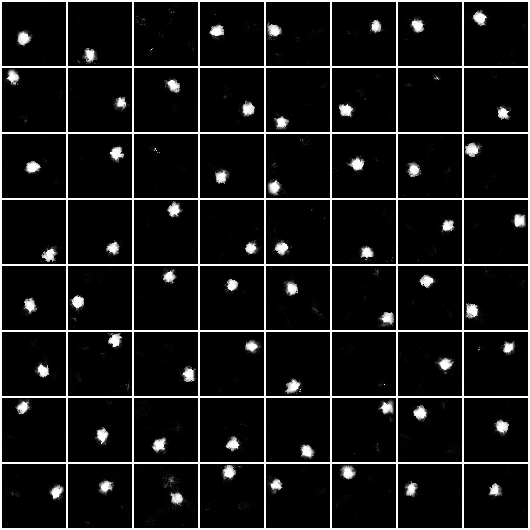

In [7]:
display(Image.open("outputs/GANs/DiscreteWGAN-FC/images/20000.png.png"))

## 2.2 -  FC discriminator with M=N
In this scenario we get copies of the training data which analytically is optimal solution for M=N.
Note that here convergence takes more time and it is helpfull to use larger batch sizes.

In [4]:
!python3 train.py --data_path black_S-10_O-1_S-1 --gray_scale  --z_prior const=2704 --gen_arch FC-nf=1024 --disc_arch FC-nf=1024 --loss_function WGANLoss --gp_weight 10 --train_name DiscreteWGAN-FC_M=N --full_batch_metrics --n_iterations 100000

Working on device: NVIDIA GeForce RTX 3060 Ti
Train images: 2704, test images: 0
G params: 4.26M, D params: 6.30M
Iteration: 0: it/sec: 1.8
Evaluation finished in 0.1159524917602539 seconds
Iteration: 100: it/sec: 42.6
Iteration: 200: it/sec: 55.6
Iteration: 300: it/sec: 59.1
Iteration: 400: it/sec: 62.7
Iteration: 500: it/sec: 65.0
Iteration: 600: it/sec: 66.2
Iteration: 700: it/sec: 67.3
Iteration: 800: it/sec: 67.7
Iteration: 900: it/sec: 68.4
Iteration: 1000: it/sec: 69.1
Evaluation finished in 0.06082868576049805 seconds
Iteration: 1100: it/sec: 67.7
Iteration: 1200: it/sec: 68.3
Iteration: 1300: it/sec: 68.9
Iteration: 1400: it/sec: 68.6
Iteration: 1500: it/sec: 69.1
Iteration: 1600: it/sec: 69.2
Iteration: 1700: it/sec: 69.6
Iteration: 1800: it/sec: 70.0
Iteration: 1900: it/sec: 70.0
Iteration: 2000: it/sec: 70.1
Evaluation finished in 0.040276288986206055 seconds
Iteration: 2100: it/sec: 69.2
Iteration: 2200: it/sec: 69.5
Iteration: 2300: it/sec: 69.8
Iteration: 2400: it/sec: 6

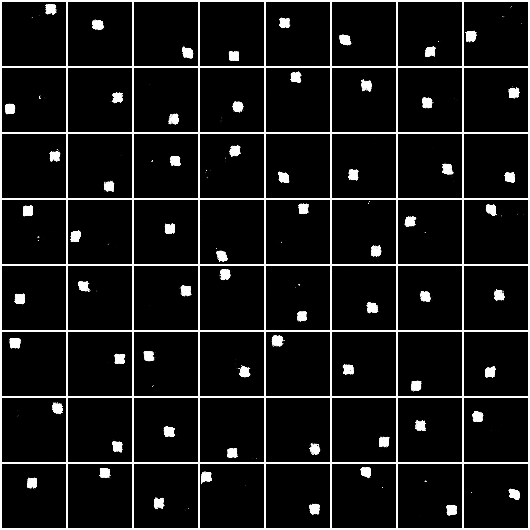

In [7]:
display(Image.open("outputs/GANs/DiscreteWGAN-FC_M=N/images/100000.png"))

## 2.3 - CNN-GAP discriminator M<N
When training with a cnn discriminator we show that the results preserve local patch distribution (sharp squares but uneven number of squares in each image) which is similar to the approximate solution reached by direct patchSWD optimization


In [10]:
!python3 train.py --data_path black_S-10_O-1_S-1 --gray_scale  --z_prior const=64 --gen_arch FC --disc_arch CNN-GAP=True --lrD 0.001 --loss_function WGANLoss --gp_weight 10 --G_step_every 5 --train_name DiscreteWGAN-CNN-GAP --full_batch_metrics MiniBatchLoss-dist=w1 MiniBatchLocalPatchLoss-dist=swd-p=16-s=8 --n_iterations 20000 --log_freq 10000

Working on device: NVIDIA GeForce RTX 3060 Ti
Train images: 2704, test images: 0
Train images: 2704, test images: 0
Discriminator receptive field is 15
GAP mode
G params: 536.70K, D params: 369.92K
Iteration: 0: it/sec: 0.9
Generating images in minibatches
Computing metrics between 2704 real and 64 fake images
	 - MiniBatchLoss-dist=w1
	 - MiniBatchLocalPatchLoss-dist=swd-p=16-s=8
Evaluation finished in 2.6628642082214355 seconds
Iteration: 100: it/sec: 17.4
Iteration: 200: it/sec: 25.4
Iteration: 300: it/sec: 30.0
Iteration: 400: it/sec: 33.2
Iteration: 500: it/sec: 35.6
Iteration: 600: it/sec: 37.2
Iteration: 700: it/sec: 38.7
Iteration: 800: it/sec: 39.6
Iteration: 900: it/sec: 40.5
Iteration: 1000: it/sec: 41.3
Iteration: 1100: it/sec: 41.8
Iteration: 1200: it/sec: 42.5
Iteration: 1300: it/sec: 43.0
Iteration: 1400: it/sec: 43.3
Iteration: 1500: it/sec: 43.5
Iteration: 1600: it/sec: 43.8
Iteration: 1700: it/sec: 44.1
Iteration: 1800: it/sec: 44.4
Iteration: 1900: it/sec: 44.5
Itera

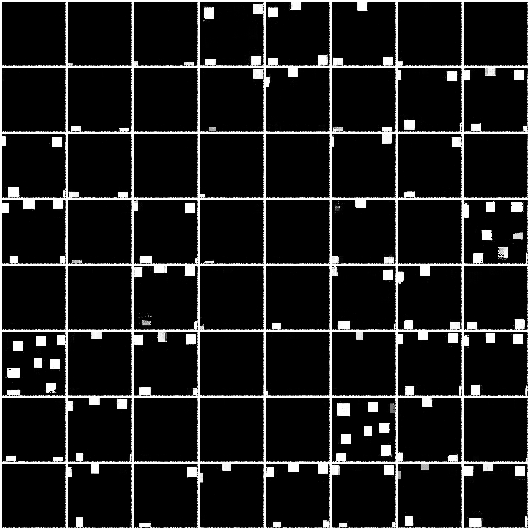

In [11]:
display(Image.open("outputs/GANs/DiscreteWGAN-CNN-GAP/images/20000.png.png"))

# 3 - Experiments with pretrained DiscreteWGAN

Here we recrate the experiments from figure 2, 8 and 13 from the paper. All of them use the model we trained on FFHQ with M=70K (ffhq size) and the data itself.



In [12]:
#@title download pretrained model and FHHQ data
import gdown
!rm -rf  pretrained_model
!gdown --folder 1rARDS6AlgIemkQmXn5iYTB5-0-2kvukm -O pretrained_model

!gdown https://drive.google.com/file/d/1Wrr6qZA1Tr6r9edNL2nSxnwopMW1n6pR/view?usp=drive_link --fuzzy
!unzip thumbnails128x128.zip -d FFHQ

Retrieving folder contents
Processing file 17njoh0v2Y3EEN4cjzzcBqOIB8T1oO8Ho args.txt
Processing file 1hYvQbMtmxSxvIf0_C3I7oc28VLFMAQrQ fastGAN_FFHQ.pth
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=17njoh0v2Y3EEN4cjzzcBqOIB8T1oO8Ho
To: /mnt/storage_ssd/university/repos/In_defence_of_wasserstein/colab_test/DiscreteGANs/pretrained_model/args.txt
100%|██████████████████████████████████████████| 887/887 [00:00<00:00, 1.90MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hYvQbMtmxSxvIf0_C3I7oc28VLFMAQrQ
From (redirected): https://drive.google.com/uc?id=1hYvQbMtmxSxvIf0_C3I7oc28VLFMAQrQ&confirm=t&uuid=2dd99897-32e1-49ce-a150-33e6a8c58fa4
To: /mnt/storage_ssd/university/repos/In_defence_of_wasserstein/colab_test/DiscreteGANs/pretrained_model/fastGAN_FFHQ.pth
100%|████████████████████████████████████████| 612M/612M [00:17<00:00, 35.6MB/s]
Download completed
Downlo

In [1]:
#@title load generator
%cd DiscreteGANs
import json
from models import get_models
from utils.train_utils import Prior
import argparse
import torch 

def load_pretrained_models(args, ckpt_path, device):
  netG, netD = get_models(args, device)

  weights = torch.load(ckpt_path, map_location=device, weights_only=True)
  netG.load_state_dict(weights['netG'])
  netG.to(device)
  netG.eval()

  netD.load_state_dict(weights['netD'])
  netD.to(device)
  netD.eval()
  prior = Prior(args.z_prior, args.z_dim)
  prior.z = weights['prior']

  return netG, netD, prior

device = 'cpu'

args = argparse.Namespace(**json.load(open("pretrained_model/args.txt")))
netG, netD, prior = load_pretrained_models(args, 'pretrained_model/fastGAN_FFHQ.pth', device)

/mnt/storage_ssd/university/new_venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/mnt/storage_ssd/university/repos/In_defence_of_wasserstein/colab_test/DiscreteGANs
G params: 24.76M, D params: 23.16M


## 3.1 - Find data nearest neighbors
As we show in the paper in figures 2 and 8. The discreteWGAN with M=N 70K produces real looking faces eventhough which are not copies of th data.

In [2]:
#@title load ffhq to memory
from evaluate.test_utils import get_data
args.data_path = "FFHQ/thumbnails128x128"
args.im_size = 64 # Perform the search in lower resolution since colab is restricted in memory # Turn off ig you have more memory
data = get_data(args.data_path, args.im_size, args.center_crop, args.gray_scale, limit_data=args.limit_data)


Loading data to memory to find NNs


100%|██████████| 70000/70000 [01:23<00:00, 833.82it/s]


### 3.1.1 - Image nearest neighbores
The output's top row are generated images and the bottom row are neareste neighbors from the dataset

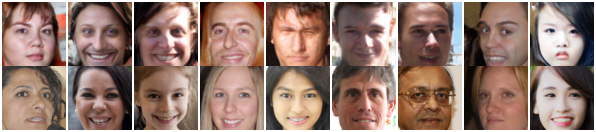

In [15]:
from evaluate.test_data_NNs import find_nns
import torchvision

fake_images = netG(prior.sample(9).to(device))

fake_images = torchvision.transforms.Resize((args.im_size, args.im_size))(fake_images).cpu()

find_nns(fake_images, data, outputs_dir=".")
display(Image.open("nns/im.png"))


### 3.1.2 - Patch nearest neighbores are similar


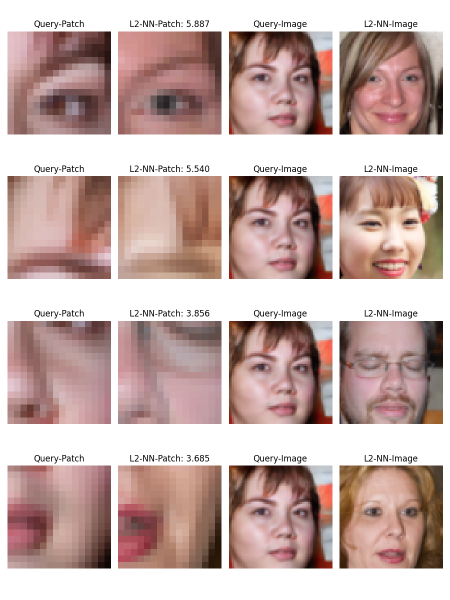

In [38]:
from evaluate.test_data_NNs import find_patch_nns

find_patch_nns(fake_images[:1], data, patch_size=16, stride=1, search_margin=4, outputs_dir=".", n_centers=4, b=64, metric_name='L2', device="cpu")

display(Image.open("L2-patch_nns(p-16_s-4)/patches-0.png").convert('RGB').reduce(2))

## 3.2 - Visualize local patch hists
We show here a comparison of real and fake patches in a specific location as was done in figure 13 of the paper. As can be seen the histograms are quite similar.
For each random patch location we sample a random matrix vector of shape pxpx3 (patch size) and project all real and fake patches in the specific location into two sets of scalars which we then create histograms for and plot.

100%|██████████| 1000/1000 [01:42<00:00,  9.73it/s]


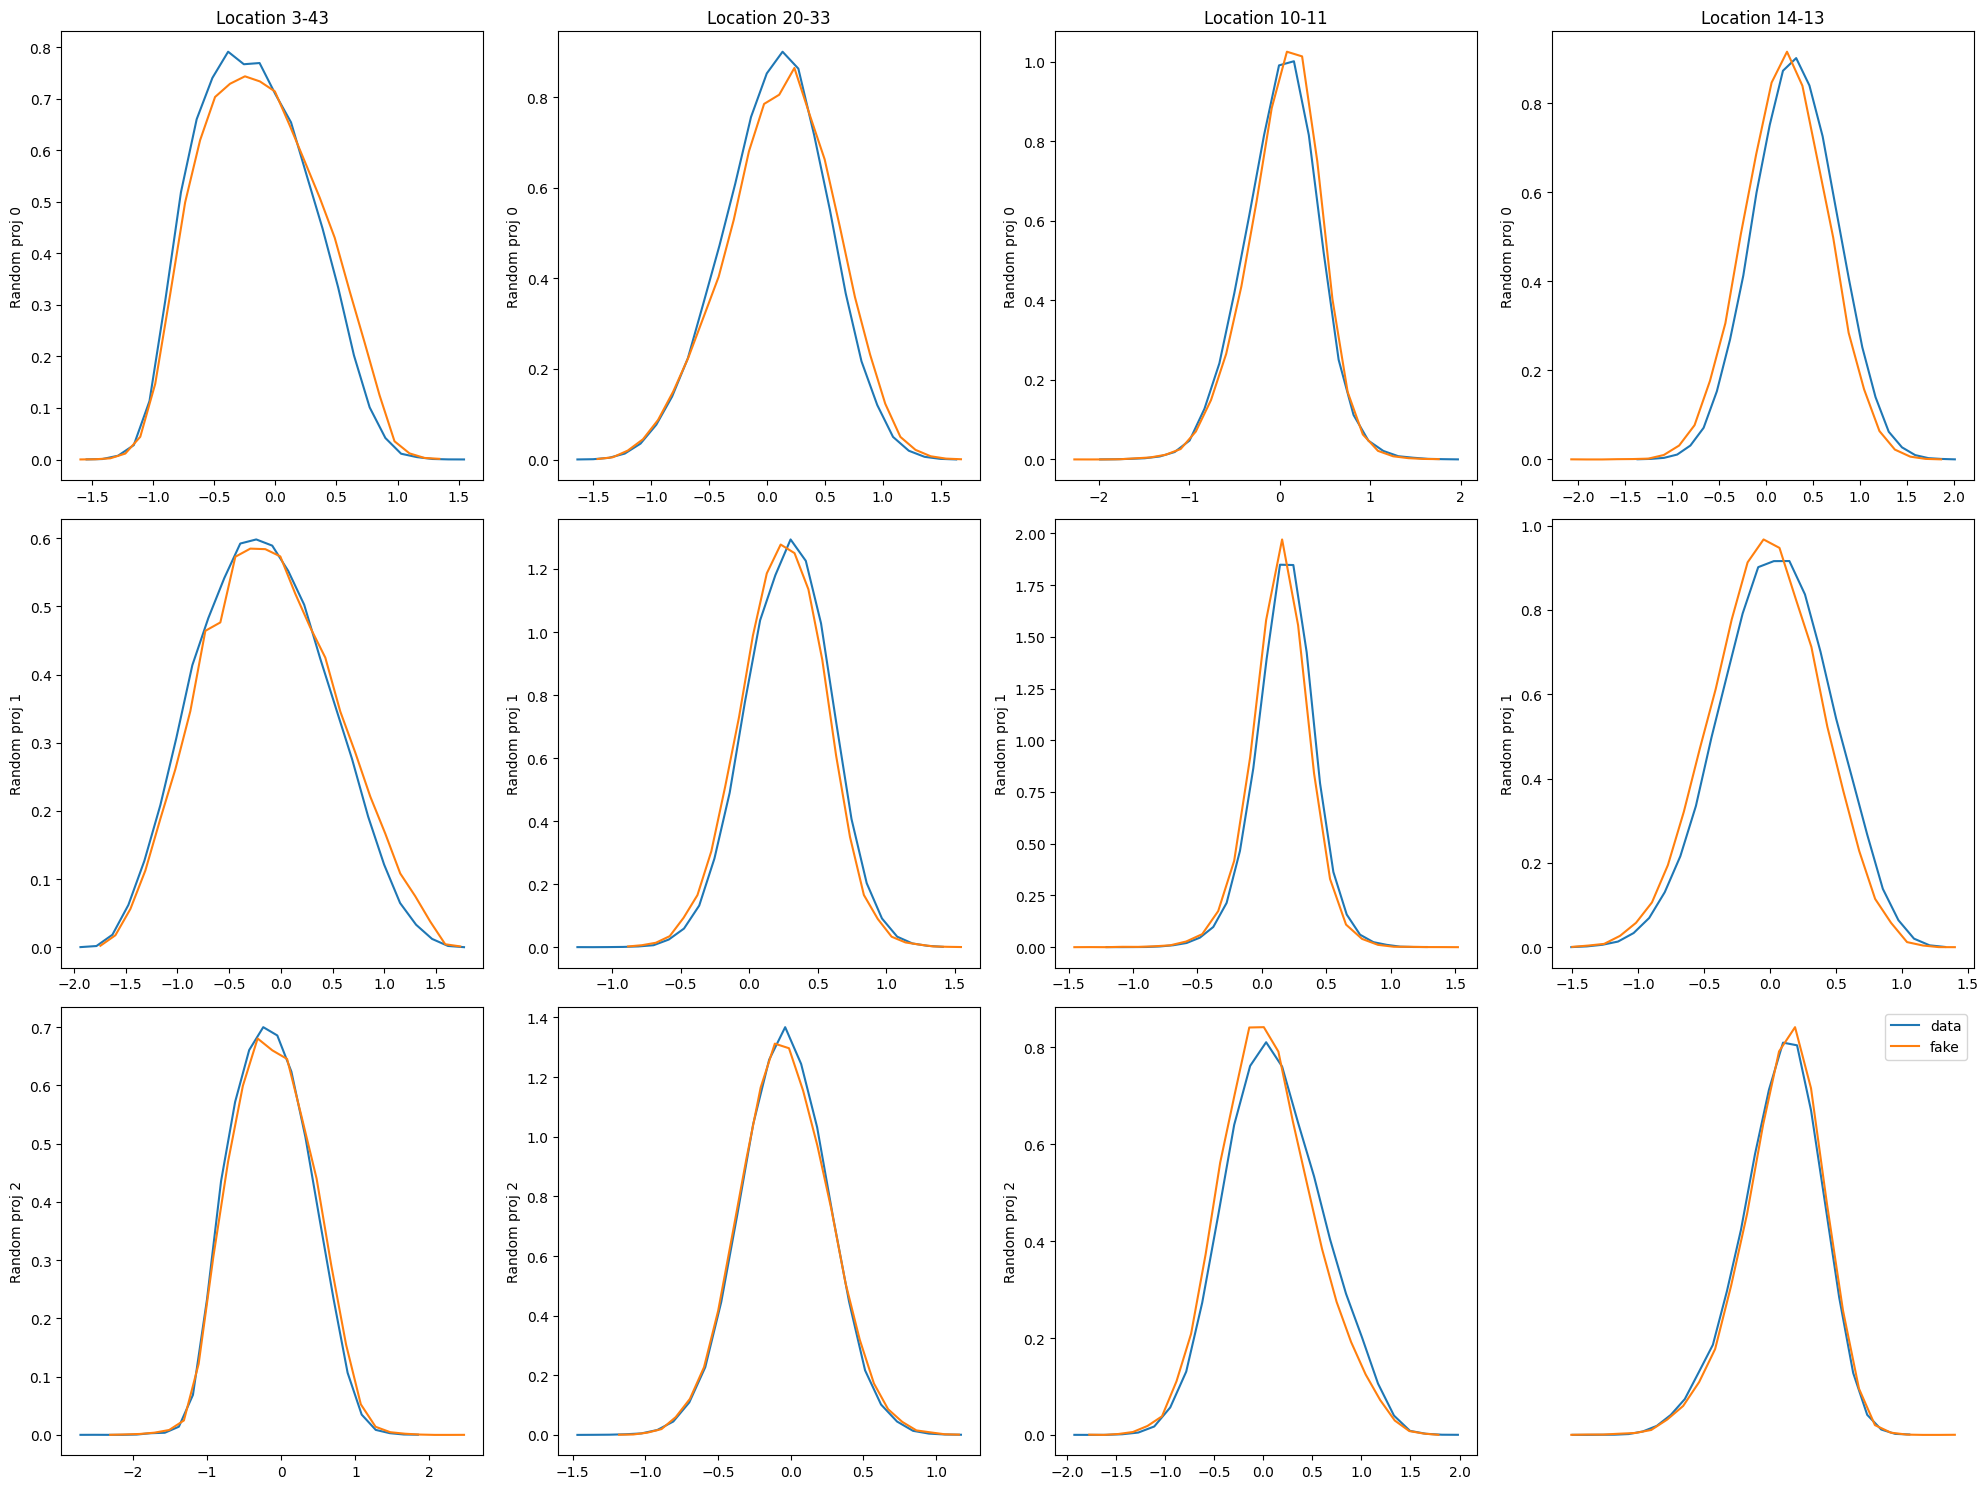

<Figure size 640x480 with 0 Axes>

In [4]:
#@title plot local patch histograms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def get_random_mat(c, p):
    rand_kernel = torch.randn((p * p * c))
    rand_kernel /= rand_kernel.norm()
    return rand_kernel


def get_random_loc(c, dim, p):
    x = np.random.randint(0, dim - p)
    y = np.random.randint(0, dim - p)
    return x, y


def get_local_hist(batch, x, y, mat):
    return batch[..., x:x + p, y:y + p].reshape(len(batch), -1) @ mat


def generate_images():
      fake_images = []
      for _ in tqdm(range(1000)):
          batch = netG(prior.sample(70).to(device)).cpu()
          batch = torchvision.transforms.Resize((args.im_size, args.im_size))(batch)
          fake_images .append(batch)
      return torch.cat(fake_images)


device = torch.device("cuda")
netG.to(device)
with torch.no_grad():
  fake_images = generate_images()
  n_locs = 4
  n_reps = 3
  p = 16 # patch size
  nbins = 25

  c=data.shape[1]
  dim=data.shape[-1]
  fig, axes = plt.subplots(n_reps, n_locs, figsize=(5*n_locs, 5*n_reps))
  for j in range(n_locs):
      x,y = get_random_loc(c, dim, p)
      for i in range(n_reps):
          if i == 0:
            axes[i,j].set_title(f"Location {x}-{y}")
          axes[i,j].set_ylabel(f"Random proj {i}")
          mat = get_random_mat(c, p)
          data_local_hist = data[..., x:x + p, y:y + p].reshape(len(data), -1) @ mat
          counts, bins = np.histogram(data_local_hist, bins=nbins, density=True)
          axes[i,j].plot(bins[:-1], counts, label='data')

          fake_local_hist = fake_images[..., x:x + p, y:y + p].reshape(len(fake_images), -1) @ mat
          counts, bins = np.histogram(fake_local_hist.numpy(), bins=nbins, density=True)
          axes[i,j].plot(bins[:-1], counts, label='fake')

  plt.legend()
  plt.tight_layout()
  plt.show()
  # plt.savefig(f"hists.png")
  plt.clf()
